In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.preprocessing import LabelBinarizer

from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines

In [3]:
load_process_and_store_spreadsheets()

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Classification

In [4]:
y_train_resp = y_train["response_grouped"] == 'responder (pr+cr)'
y_test_resp = y_test["response_grouped"] == 'responder (pr+cr)'

In [5]:
ps = build_classifier_pipelines()
benchmark_pipelines(
    ps, X_train, y_train_resp, X_test, y_test_resp
)

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeClassifier,0.631579,0.394737,0.710526,0.552632
RandomForestClassifier,0.736842,0.605263,0.710526,0.605263
GradientBoostingClassifier,0.710526,0.789474,0.763158,0.763158
KNeighborsClassifier,0.763158,0.657895,0.815789,0.526316
LogisticRegression,0.763158,0.657895,0.763158,0.684211
SVC,0.763158,0.763158,0.763158,0.763158
DummyClassifier,0.763158,0.763158,0.763158,0.763158


In [6]:
b = benchmark_pipelines(
    ps, X_train, y_train_resp, X_test, y_test_resp, metric=f1_score,
)
b

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeClassifier,0.125000,0.410256,0.153846,0.320000
RandomForestClassifier,0.285714,0.400000,0.153846,0.285714
GradientBoostingClassifier,0.000000,0.200000,0.000000,0.000000
KNeighborsClassifier,0.400000,0.235294,0.533333,0.181818
LogisticRegression,0.000000,0.434783,0.000000,0.250000
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


In [7]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    0.115816
Julian_test     0.240048
Lev_test        0.120147
Freeman_test    0.148219
dtype: float64
--------------------
DecisionTreeClassifier        0.252276
RandomForestClassifier        0.281319
GradientBoostingClassifier    0.050000
KNeighborsClassifier          0.337611
LogisticRegression            0.171196
SVC                           0.000000
DummyClassifier               0.000000
dtype: float64


In [8]:
p_win = ps['KNeighborsClassifier']['Lev']

In [9]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=y_test_resp.unique())

Confusion matrix, without normalization
[[27  2]
 [ 5  4]]


In [10]:
recall = benchmark_pipelines(
    ps, X_train, y_train_resp, X_test, y_test_resp, metric=recall_score,
)
recall

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeClassifier,0.111111,0.888889,0.111111,0.444444
RandomForestClassifier,0.222222,0.555556,0.111111,0.333333
GradientBoostingClassifier,0.000000,0.111111,0.000000,0.000000
KNeighborsClassifier,0.333333,0.222222,0.444444,0.222222
LogisticRegression,0.000000,0.555556,0.000000,0.222222
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


Confusion matrix, without normalization
[[ 7 22]
 [ 1  8]]


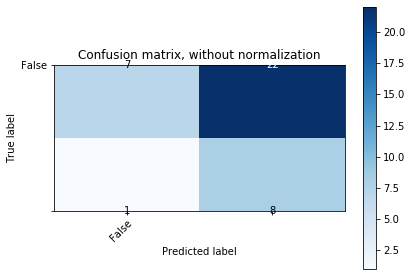

In [11]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, ps['DecisionTreeClassifier']['Julian'].predict(X_test), classes=y_test_resp.unique())

## Regression
### Overall survival (OS)

In [12]:
y_train_os = y_train['OS_days']
y_test_os = y_test['OS_days']

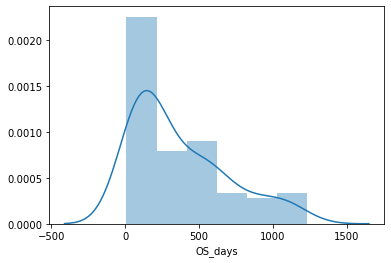

In [13]:
import seaborn as sns
sns.distplot(y_train_os)

In [14]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_os, X_test, y_test_os, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [15]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    338.450430
Julian_test     471.193374
Lev_test        358.775517
Freeman_test    696.564050
dtype: float64
--------------------
DecisionTreeRegressor         388.688322
RandomForestRegressor         320.625260
GradientBoostingRegressor     318.369799
KNeighborsRegressor           314.280700
ElasticNet                   1367.658187
SVR                           277.025821
DummyRegressor                277.072810
dtype: float64


In [16]:
b

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeRegressor,445.200073,376.954996,315.536252,417.061967
RandomForestRegressor,381.087881,300.321436,303.593660,297.498063
GradientBoostingRegressor,350.547739,305.906495,290.891197,326.133765
KNeighborsRegressor,369.776634,282.097732,309.825511,295.422924
ElasticNet,268.423645,1478.998208,737.486268,2985.724628
SVR,277.044226,277.001938,277.022925,277.034194
DummyRegressor,277.072810,277.072810,277.072810,277.072810


## Progression Free Survival (PFS)

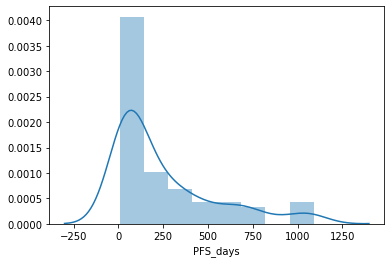

In [17]:
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']
sns.distplot(y_train_pfs)

In [18]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_pfs, X_test, y_test_pfs, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [19]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    323.180659
Julian_test     453.483542
Lev_test        355.693919
Freeman_test    598.379452
dtype: float64
--------------------
DecisionTreeRegressor         359.982633
RandomForestRegressor         300.892476
GradientBoostingRegressor     308.223558
KNeighborsRegressor           317.109069
ElasticNet                   1145.154998
SVR                           298.705474
DummyRegressor                298.722543
dtype: float64


In [20]:
b

,Richard_test,Julian_test,Lev_test,Freeman_test
DecisionTreeRegressor,403.770518,371.443017,334.099712,330.617286
RandomForestRegressor,314.929484,302.365499,283.823568,302.451351
GradientBoostingRegressor,318.572982,308.636838,293.892734,311.791677
KNeighborsRegressor,353.867007,292.588619,312.354887,309.625761
ElasticNet,273.691629,1301.929397,668.259437,2336.739530
SVR,298.710452,298.698878,298.704555,298.708013
DummyRegressor,298.722543,298.722543,298.722543,298.722543
